In [1]:
%matplotlib inline

import warnings
import os

import pandas as pd
import numpy as np

from sklearn.linear_model import  LinearRegression
from numpy.linalg.linalg import LinAlgError
from itertools import product
from pylab import rcParams
from scipy import stats
from tqdm import tqdm 

from matplotlib import pyplot as plt
from statsmodels import api as sm


rcParams['figure.figsize'] = 15, 8
warnings.filterwarnings('ignore')
PATH_TO_DATA = '../data'

C:\Users\Public\PythonProjects\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### 1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [2]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_1282.csv'), index_col=0, parse_dates=[0])

print(train_df.shape)
train_df.head()

(4392, 1)


,1282
2016-01-01 00:00:00,1076.0
2016-01-01 01:00:00,1178.0
2016-01-01 02:00:00,1053.0
2016-01-01 03:00:00,610.0
2016-01-01 04:00:00,401.0


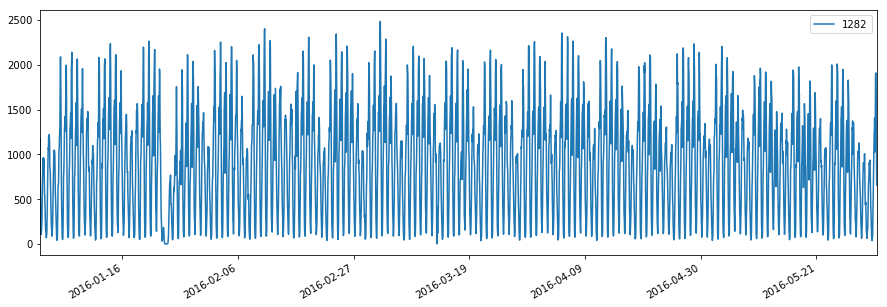

In [3]:
_ = train_df.plot(figsize=(15,5))

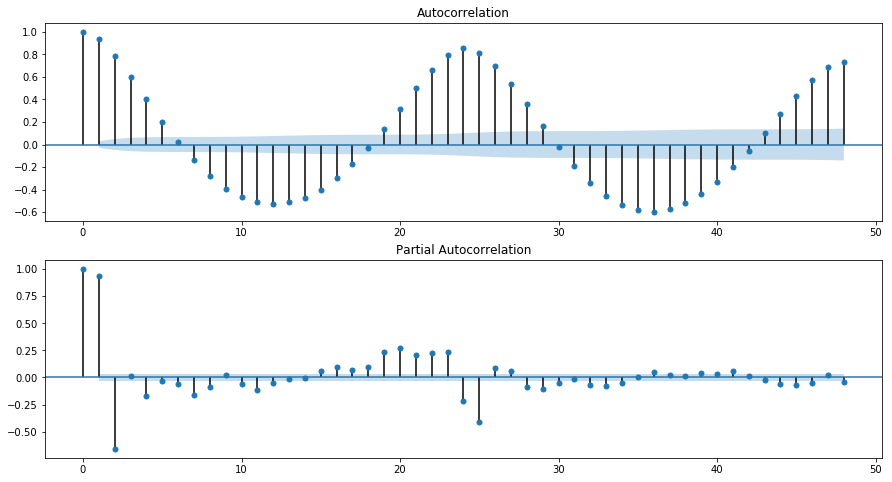

In [4]:
_, ax = plt.subplots(2, 1, figsize=(15, 8))
sm.graphics.tsa.plot_acf(train_df['1282'].values.squeeze(), lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_df['1282'].values.squeeze(), lags=48, ax=ax[1])
plt.show()

In [5]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['1282'])[1])

Критерий Дики-Фуллера: p=0.000000


#### 2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

Для учёта недельной сезонности используются регрессионные признаки следующего вида:

<center>$s_{i}=\sin([1,…,T]∗2πi/168), c_{i}=\cos([1,…,T]∗2πi/168), i=1,…,K.$</center>

In [6]:
hours_in_day = 24

sin_day = np.sin(np.array(range(1, hours_in_day + 1)) * 2 * np.pi / (hours_in_day))
sin_day = np.tile(sin_day, int(train_df.shape[0] / len(sin_day) + 1))

hours_in_week = 7 * 24
sin_week = np.sin(np.array(range(1, hours_in_week + 1)) * 2 * np.pi / (hours_in_week))
sin_week = np.tile(sin_week, int(train_df.shape[0] / len(sin_week) + 2))

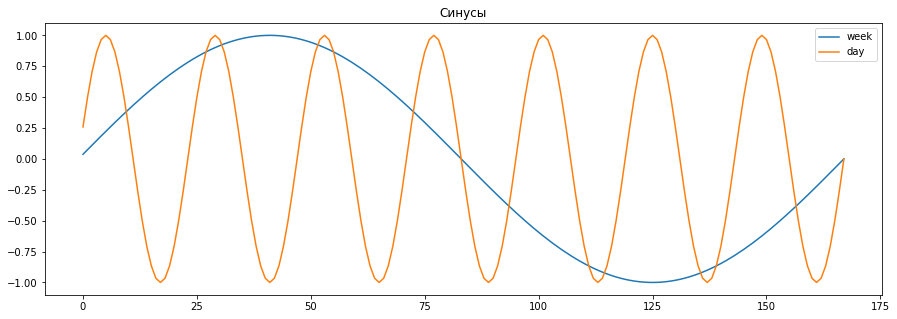

In [7]:
fig = plt.figure(figsize=(15,5))
plt.plot(sin_week[:hours_in_week], label = 'week')
plt.plot(sin_day[:hours_in_week], label = 'day')
plt.title('Синусы')
_ = plt.legend()

In [8]:
days = {'sin_day_%d' % i: sin_day[i: train_df.shape[0] + i] for i in range(hours_in_day)}
weeks = {'sin_week_%d' % i: sin_week[i: train_df.shape[0] + i] for i in range(hours_in_week)}
values = {**days, **weeks}

sin_df = pd.DataFrame(values)

In [9]:
y = train_df['1282'].values
X = sin_df.values

In [10]:
y.shape, X.shape

((4392,), (4392, 192))

In [23]:
model = LinearRegression().fit(X, y)
y_pred =  model.predict(X)
residuals = y - y_pred

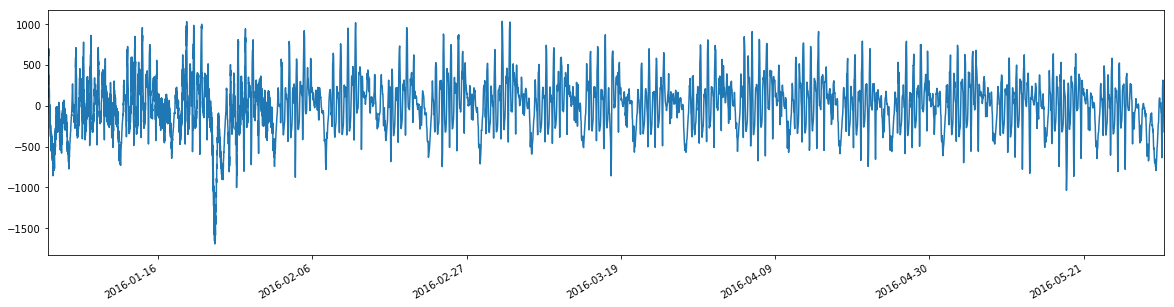

In [12]:
train_df['residuals'] = residuals
_ = train_df['residuals'].plot(figsize=(20,5))

Критерий Дики-Фуллера: p=0.000000


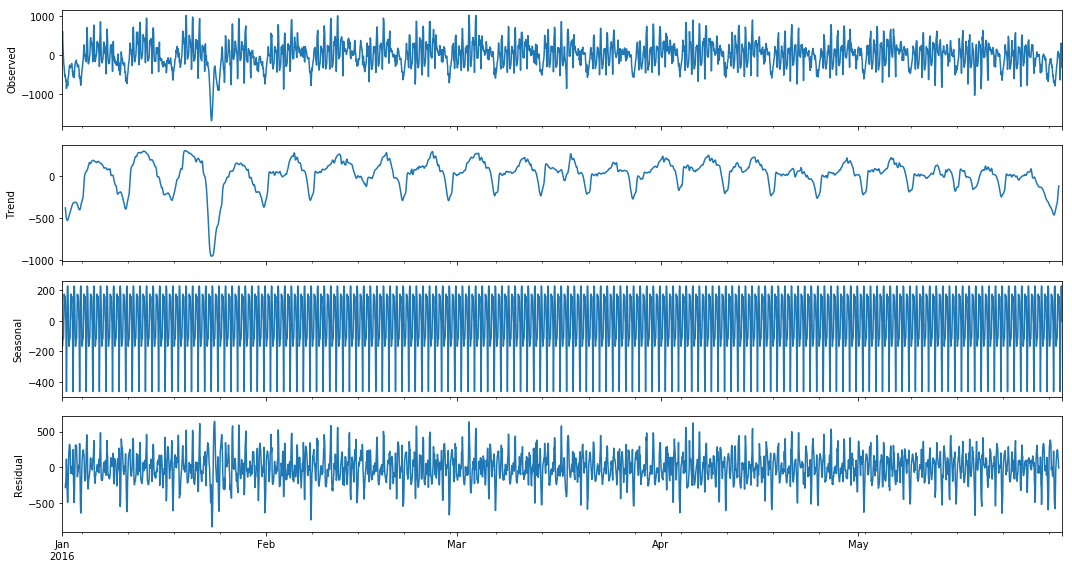

In [13]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.residuals.asfreq('H')).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.residuals)[1])

#### 3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

Критерий Дики-Фуллера: p=0.000000


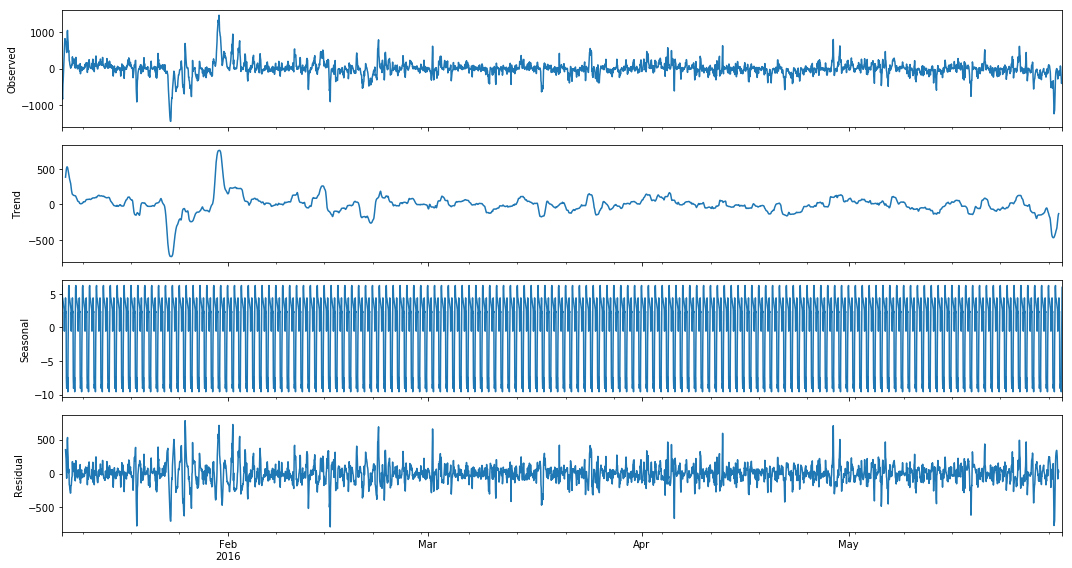

In [14]:
train_df['dif'] = train_df.residuals - train_df.residuals.shift(hours_in_week)
sm.tsa.seasonal_decompose(train_df.dif[hours_in_week:].asfreq('H')).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.dif[hours_in_week:])[1])

#### 4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

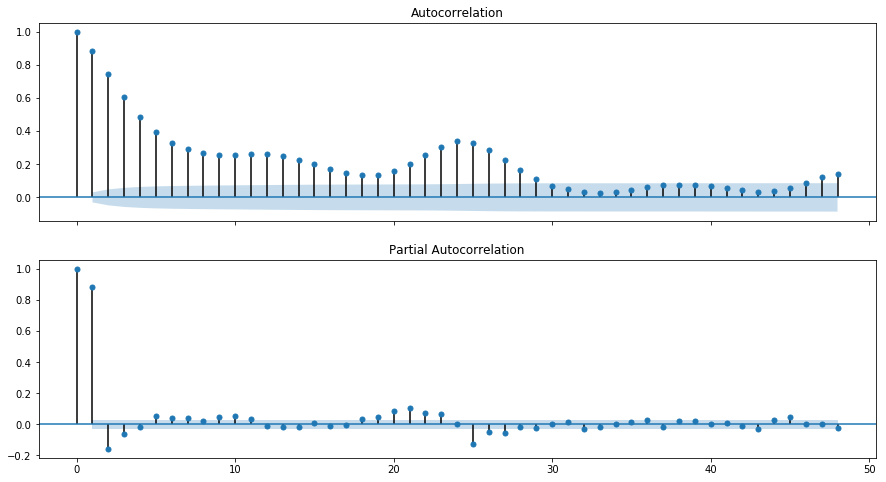

In [15]:
_, ax = plt.subplots(2, 1, sharex=True)
sm.graphics.tsa.plot_acf(train_df.dif[hours_in_week:].values.squeeze(), lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_df.dif[hours_in_week:].values.squeeze(), lags=48, ax=ax[1])
plt.show()

In [16]:
p = range(2)
q = range(4)
P = range(1)
Q = range(2)

d, D = 1, 1

parameters = list(product(p, q, P, Q))
len(parameters)

16

In [17]:
%%time
results = []
best_aic = float("inf")

for param in parameters:
    try:
        model=sm.tsa.statespace.SARIMAX(train_df.residuals, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except LinAlgError:
        continue
    except ValueError:
        continue
        
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Wall time: 2min 27s


#### 5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [20]:
result_df = pd.DataFrame(results)
result_df.columns = ['parameters', 'aic']
result_df.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
12,"(1, 3, 0, 1)",54956.240415
6,"(0, 3, 0, 1)",55409.285764
2,"(0, 1, 0, 1)",55472.782075
4,"(0, 2, 0, 1)",55473.104409
10,"(1, 1, 0, 1)",55473.653848


In [21]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          residuals   No. Observations:                 4392
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 12)   Log Likelihood              -27472.120
Date:                            Sun, 29 Oct 2017   AIC                          54956.240
Time:                                    21:05:43   BIC                          54994.566
Sample:                                01-01-2016   HQIC                         54969.761
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7276      0.013     56.594      0.000       0.702       0.753
ma.L1         -0.4344      0.018    -23.616      0.000      -0.470      -0.398
ma.L2         -0.4117      0.014    -29.873      0.000      -0.439      -0.385
ma.L3         -0.1462      0.017     -8.748      0.000      -0.179      -0.113
ma.S.L12      -1.0000      1.397     -0.716      0.474      -3.739       1.739
sigma2      1.618e+04   2.25e+04      0.717      0.473    -2.8e+04    6.04e+04
===================================================================================
Ljung-Box (Q):                     2069.13   Jarque-Bera (JB):               357.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.00
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

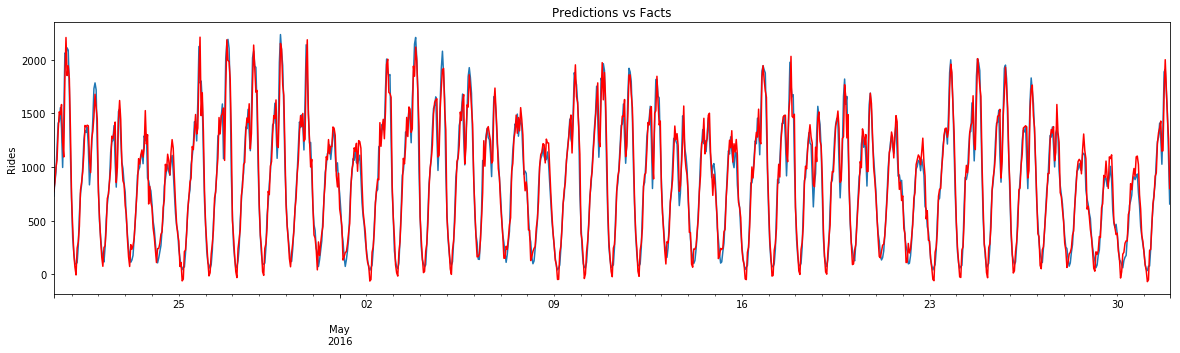

In [24]:
train_df['pred'] = best_model.fittedvalues + y_pred

plt.figure(figsize=(20,5))
train_df['1282'][-1000:].plot()
train_df.pred[-1000:].plot(color='r')
plt.title('Predictions vs Facts')
plt.ylabel('Rides')
plt.show()

Модель выдает очень даже адекватные предсказания, по крайней мере на тот период на котором она обучалась.